In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import urllib.request
import tarfile
import re
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
dataset_url='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset_dir='./datasets/'
dataset_path='datasets/aclImdb_v1.tar.gz'

os.makedirs(dataset_dir) if not os.path.exists(dataset_dir) else None    
if not os.path.exists('datasets/aclImdb'):
    if not os.path.isfile(dataset_path):
        result=urllib.request.urlretrieve(dataset_url,dataset_path)
        print('dataset does not exist, downloading it now:',result)
        with tarfile.open(dataset_path,'r:gz') as tfile:
            tfile.extractall('datasets/')
        print('dataset zip has not been extracted, extracted')
        os.remove(dataset_path)
    else: 
        print(dataset_path,'dataset zip found!')
        with tarfile.open(dataset_path,'r:gz') as tfile:
            tfile.extractall('datasets/')
        print('dataset zip has not been extracted, extracted')
        os.remove(dataset_path)
else:
    print('extracted dataset been found!')

extracted dataset been found!


In [3]:
def read_file(filetype):
    fileList=[]
    fileDir='datasets/aclImdb/'
    postiveFileDir=fileDir+filetype+'/pos/'
    negitiveFileDir=fileDir+filetype+'/neg/'
    for f in os.listdir(postiveFileDir):
        fileList+=[postiveFileDir+f]
    positiveFileNum=len(fileList)
    for f in os.listdir(negitiveFileDir):
        fileList+=[negitiveFileDir+f]
    negitiveFileNum=len(fileList)-positiveFileNum
    
    print('read',filetype,'files:',len(fileList))
    print(positiveFileNum,'positive file in',filetype,'files')
    print(negitiveFileNum,'negitive file in',filetype,'files')

    allLabels=([[1,0]]*positiveFileNum+[[0,1]]*negitiveFileNum)
    allTexts=[]
    for f in fileList:
        with open(f,encoding='utf8') as file:
            text=' '.join(file.readlines())
            re_tag=re.compile(r'<[^>]+>')
            text=re_tag.sub('',text)
            allTexts+=[text]
    
    return allTexts,allLabels

In [4]:
trainTexts,trainLabels=read_file('train')
testTexts,testLabels=read_file('test')

token=tf.keras.preprocessing.text.Tokenizer(num_words=4000)
token.fit_on_texts(trainTexts)
trainTexts=token.texts_to_sequences(trainTexts)
testTexts=token.texts_to_sequences(testTexts)

xTrain=tf.keras.preprocessing.sequence.pad_sequences(trainTexts,padding='post',truncating='post',maxlen=400)
xTest=tf.keras.preprocessing.sequence.pad_sequences(testTexts,padding='post',truncating='post',maxlen=400)
yTrain=np.array(trainLabels)
yTest=np.array(testLabels)

read train files: 25000
12500 positive file in train files
12500 negitive file in train files
read test files: 25000
12500 positive file in test files
12500 negitive file in test files


In [5]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=4000,input_length=400,output_dim=32))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8)))
model.add(tf.keras.layers.Dense(units=32,activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 32)           128000    
                                                                 
 bidirectional (Bidirectiona  (None, 16)               2624      
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 131,234
Trainable params: 131,234
Non-trainable params: 0
__________________________________________________

In [6]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(xTrain,yTrain,validation_split=0.2,epochs=20,batch_size=128,verbose=0)

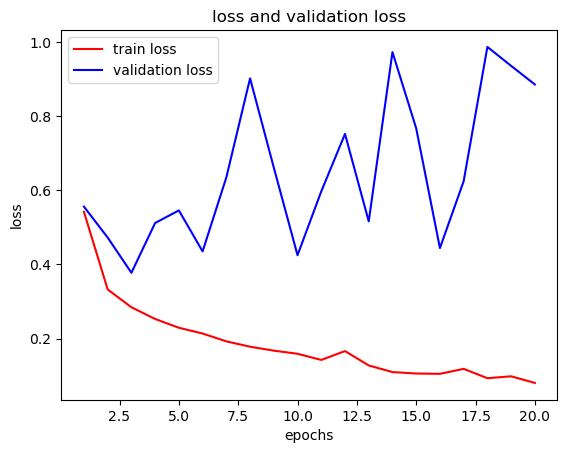

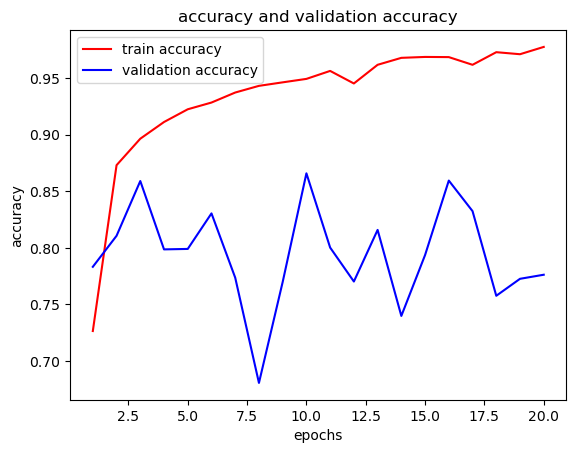

In [7]:
trainAcc=history.history['accuracy']
trainLoss=history.history['loss']
trainValAcc=history.history['val_accuracy']
trainValLoss=history.history['val_loss']
trainEpochs=range(1,len(trainAcc)+1)

plt.plot(trainEpochs,trainLoss,'r',label='train loss')
plt.plot(trainEpochs,trainValLoss,'b',label='validation loss')
plt.title('loss and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(trainEpochs,trainAcc,'r',label='train accuracy')
plt.plot(trainEpochs,trainValAcc,'b',label='validation accuracy')
plt.title('accuracy and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [8]:
testLoss,testAcc=model.evaluate(xTest,yTest,verbose=0)
print('test accuracy is: {:.4f}%, test loss is: {:.4f}%'.format(testAcc*100,testLoss*100))

test accuracy is: 83.1120%, test loss is: 65.8380%


In [9]:
def display_text_sentiment(text):
    sentimentDictionary={0:'positive',1:'negitive'}
    text=token.texts_to_sequences([text])
    text=tf.keras.preprocessing.sequence.pad_sequences(text,padding='post',truncating='post',maxlen=400)
    prediction=model.predict(text,verbose=0)
    print('predict value for this review is:',sentimentDictionary[np.argmax(prediction)])

reviewText='This is a good movie.'
display_text_sentiment(reviewText)

predict value for this review is: positive
